In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures as polyfeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gspread as gs
import gspread_dataframe as gd
import copy
import itertools

%matplotlib inline
plt.style.use('fivethirtyeight')

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2,read_consesus,read_fre
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,8.0,88.77
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,6.0,89.99
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,6.0,99.77


In [3]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [4]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

# in this case it is straightforward - just drop the 3 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

Top 5 cols with missing data per col:
tss_pac_9     3
tss_qua_2     3
tss_rep_9     3
tss_coh_2     3
tss_cre_10    3
dtype: int64

Top 5 missing data per row:
117    72
137    65
77     35
172     0
173     0
dtype: int64


In [5]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     51.205479
std      10.237403
min      29.000000
25%      44.000000
50%      52.000000
75%      60.000000
max      69.000000
dtype: float64


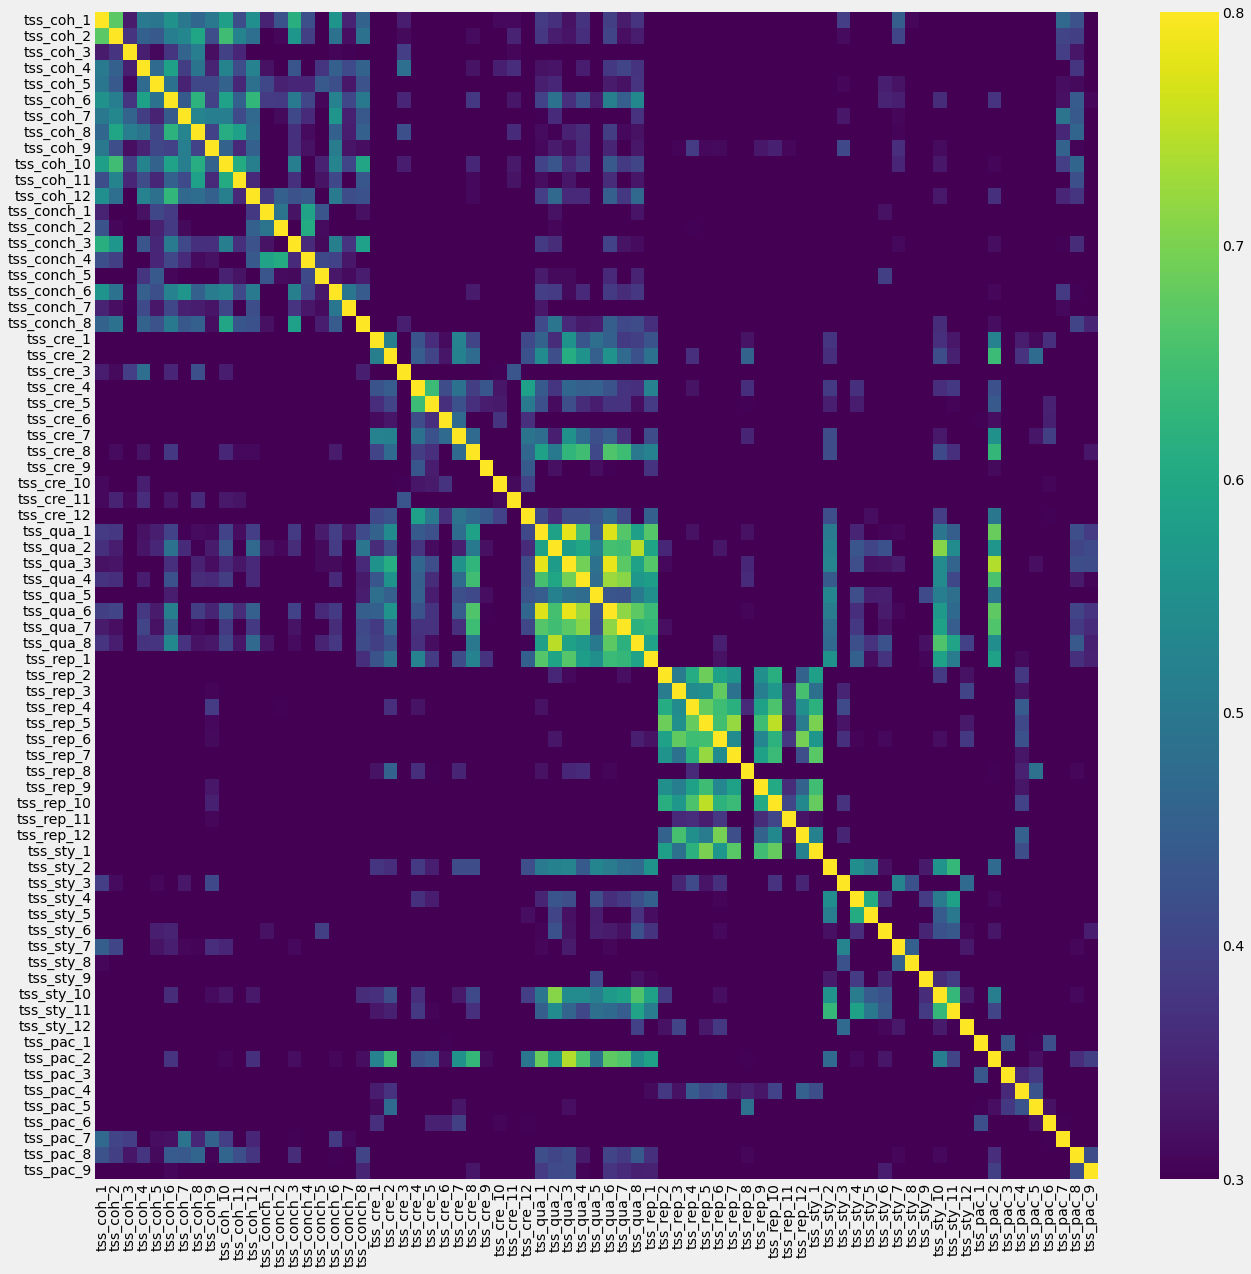

In [6]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [7]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_10", "tss_cre_11",
    "tss_rep_8", "tss_rep_10",
    "tss_sty_8", "tss_sty_9", "tss_sty_12"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6", "tss_pac_9"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_cre_10: The story was unconventional.
Correlations >= .3:
tss_coh_1     0.309783
tss_cre_4     0.328302
tss_cre_5     0.334503
tss_cre_6     0.372716
tss_cre_12    0.397940
tss_pac_6     0.306827

tss_cre_11: The plot was typical for this kind of story.
Correlations >= .3:
tss_coh_3     0.307965
tss_coh_4     0.362625
tss_coh_6     0.329026
tss_coh_8     0.359690
tss_coh_10    0.331427
tss_coh_11    0.324806
tss_cre_3     0.431698

tss_rep_8: The plot had no development.
Correlations >= .3:
tss_cre_2    0.457652
tss_rep_4    0.357334
tss_pac_4    0.346663
tss_pac_5    0.484301

tss_rep_10: Characters said or did the same thing many times over.
Correlations >= .3:
tss_coh_9     0.343786
tss_rep_3     0.566444
tss_rep_4     0.659350
tss_rep_5     0.749587
tss_rep_6     0.622229
tss_rep_7     0.637944
tss_rep_9     0.601020
tss_rep_11    0.404732
tss_rep_12    0.532795
tss_sty_1     0.681332
tss_sty_3     0.371317
tss_pac_4     0.397760

tss_sty_8: The writing style was too complicate

In [8]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

# excluded_items_li = [
#     "tss_sty_8"
# ]

# for item in excluded_items_li:
#     items_analysis_li.remove(item)

In [9]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr=[], print_details=True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())

        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(
                vif_max[0], vif_max[1]))

            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")

        reduced_vars.remove(vif_max[0])

        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)

    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(
        count_removed, len(reduced_vars)))

    return(reduced_vars)

In [10]:
items_analysis_li = reduce_multicoll(
    tss_df, items_analysis_li, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 7.021971237217733e-24

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 41.19
('The story was fun to read.')

Excluded item tss_coh_1. VIF: 32.93
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_coh_12. VIF: 32.45
('The story lacked logic.')

Excluded item tss_qua_6. VIF: 29.71
('I liked this story.')

Excluded item tss_cre_4. VIF: 26.85
('The story was creative.')

Excluded item tss_rep_5. VIF: 25.76
('In the story, the same things happened again and again.')

Excluded item tss_conch_5. VIF: 25.54
('The descriptions of characters in the story were plausible.')

Excluded item tss_cre_2. VIF: 24.60
('The story was boring.')

Excluded item tss_rep_4. VIF: 24.45
('The story was very repetitive.')

Excluded item tss_conch_3. VIF: 23.96
('My understanding of the characters in the story is unclear.')

Excluded

In [11]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8358941982379087
All item KMOs are >.6


In [12]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k=100, facs_to_display=15, print_graph=True, print_table=True):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()

    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[
                               1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)

    if print_graph:
        # Draw graph
        plt.figure(figsize=(10, 6))

        # Line for eigenvalue 1
        plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
        # For the random data (parallel analysis)
        plt.plot(range(1, len(par_95per[:facs_to_display])+1),
                 par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
        # Markers and line for actual EFA eigenvalues
        plt.scatter(
            range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
        plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
                 ev_efa[:facs_to_display], label='EVs - survey data')

        plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
        plt.xlabel('Components', {'fontsize': 15})
        plt.xticks(ticks=range(1, facs_to_display+1),
                   labels=range(1, facs_to_display+1))
        plt.ylabel('Eigenvalue', {'fontsize': 15})
        plt.legend()
        plt.show()

    if print_table:
        # Create simple table with values for 95th percentile for random data and EVs for actual data
        print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
              format(k, facs_to_display))
        print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

        last_index = 0
        last_95per_par = 0
        last_ev_efa = 0
        found_threshold = False

        # Loop that prints previous (!) values
        # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
        # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
        for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
            cur_ev_efa = ev_efa[index-1]
            if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
                found_threshold = True
                print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                    last_index, last_95per_par, last_ev_efa))
            elif (index > 1):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    last_index, last_95per_par, last_ev_efa))

            if index == len(par_95per[:facs_to_display]):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    index, cur_ev_par, cur_ev_efa))

            last_index = index
            last_95per_par = cur_ev_par
            last_ev_efa = cur_ev_efa

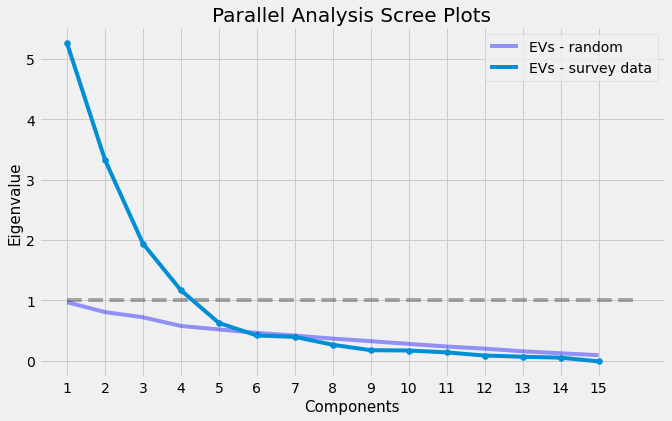

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.97				5.26
2	0.80				3.33
3	0.72				1.94
4	0.58				1.17
5	0.52				0.63
6	0.46				0.42
7	0.42				0.39
8	0.37				0.26
9	0.32				0.17
10	0.28				0.17
11	0.24				0.14
12	0.20				0.09
13	0.16				0.07
14	0.12				0.05
15	0.09				-0.01


In [13]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

## 5 factor solution

In [15]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=5, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique


Factor Correlation Matrix (Oblique Rotation):
[[ 1.         -0.06157208 -0.23885716  0.11344515 -0.4003166 ]
 [-0.06157208  1.         -0.13240268  0.23719791 -0.0373796 ]
 [-0.23885716 -0.13240268  1.         -0.04786346  0.27671305]
 [ 0.11344515  0.23719791 -0.04786346  1.         -0.17747933]
 [-0.4003166  -0.0373796   0.27671305 -0.17747933  1.        ]]


In [16]:
def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                  print_details=False, print_par_plot=False, print_par_table=False,
                  par_k=100, par_n_facs=15):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # print screeplot and/or table for parallel analysis if option was chosen
        # but not for first run (assuming it was already checked to select number of factors)
        if (i > 1) and print_par_plot or print_par_table:
            parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                              print_graph=print_par_plot, print_table=print_par_table)

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking high cross loadings")

        # create df that stores main_load, largest crossload and difference between the two
        crossloads_df = pd.DataFrame(index=curr_vars)

        crossloads_df["main_load"] = abs(loadings).max(axis=1)
        crossloads_df["cross_load"] = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        crossloads_df["diff"] = crossloads_df["main_load"] - \
            crossloads_df["cross_load"]

        mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
            crossloads_df["diff"] < load_diff_thresh)

        if crossloads_df[mask_high_cross].empty:
            print("All cross_loadins loadings below {}".format(cross_thres),
                  "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
        else:
            # save bad items and remove them
            bad_items = crossloads_df[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print(
                "Consider using stricer criteria and/or removing highly correlated vars")

        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))

        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def print_sorted_loadings(efa, item_lables, load_thresh=0.4, descr=[]):
    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        mask_relev_loads = abs(loadings[i]) > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print("Relevant loadings for factor {}".format(i))
        if len(descr) > 0:
            print(sorted_loads[[i, "descr"]].to_string(), "\n")
        else:
            print(sorted_loads[i].to_string(), "\n")


def rev_items_and_return(df, efa, item_lables, load_thresh=0.4, min_score=1, max_score=5):

    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    items_per_fact_dict = {}

    # loop through n factors
    # determine relevant items that are positive (can just be used as is)
    # and items with negative loads (need to be refersed)
    for i in range(0, n_load):
        mask_pos_loads = loadings[i] > load_thresh
        mask_neg_loads = loadings[i] < -load_thresh
        pos_items = loadings[mask_pos_loads].index.tolist()
        neg_items = loadings[mask_neg_loads].index.tolist()

        # add items with positive items directly to dict
        items_per_fact_dict[i] = pos_items

        # create reverse-coded item in df for items with negative loadings
        for item in neg_items:
            rev_item_name = item + "_rev"
            df[rev_item_name] = (df[item] - (max_score+min_score)) * -1
            items_per_fact_dict[i].append(rev_item_name)

    return items_per_fact_dict

Fitted solution #1

Checking for low communalities
Detected 2 items with low communality. Excluding them for next analysis.

Removed item tss_conch_7: How characters in the story acted seemed implausible.
Communality: 0.1905

Removed item tss_cre_9: The setting of the story was original.
Communality: 0.1906

Fitted solution #2



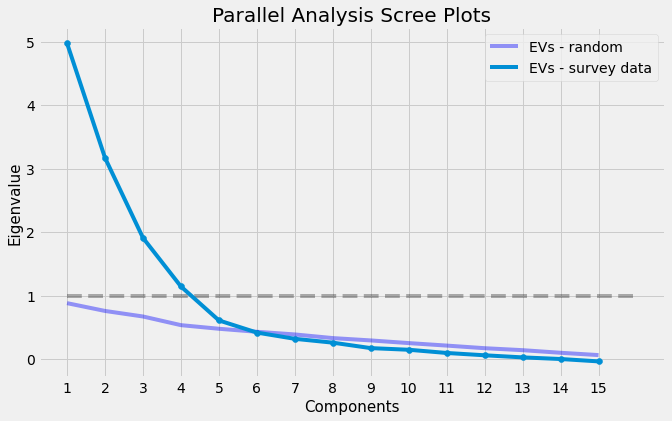

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_pac_9: There's nothing superfluous or unnecessary in this story.
Main (absolute) Loading: 0.3913

Fitted solution #3



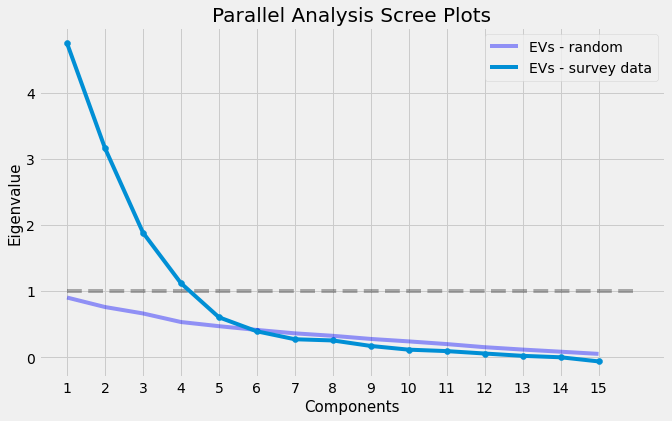

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_sty_3: The story had sentences that were unreadable
Main (absolute) Loading: 0.3958

Fitted solution #4



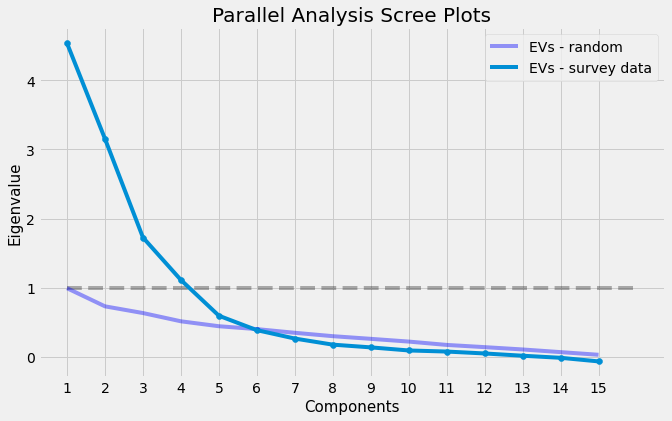

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_cre_6: It was surprising how things turned out in the story.
Main (absolute) Loading: 0.3898

Fitted solution #5



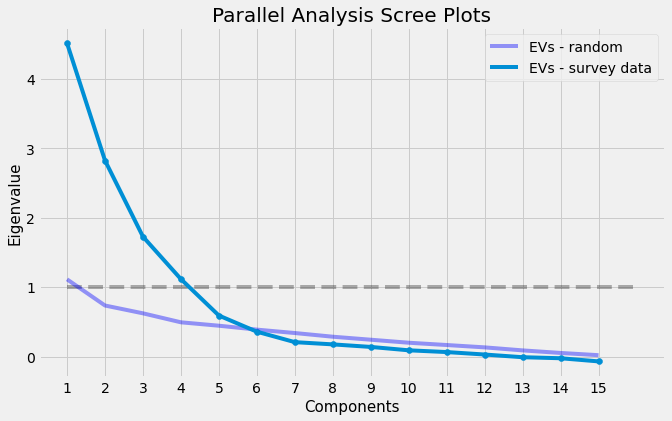

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 4 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.469430
1    0.069233
2    0.137698
3    0.357274
4    0.127656
Name: tss_coh_9, dtype: float64

Removed item tss_cre_7: There were interesting twists and turns in the story.
Loadings: 
0    0.069173
1   -0.431554
2    0.453005
3    0.041075
4   -0.003568
Name: tss_cre_7, dtype: float64

Removed item tss_qua_7: I would like to read more stories like this one.
Loadings: 
0    0.391982
1   -0.075885
2    0.464590
3   -0.172295
4    0.039662
Name: tss_qua_7, dtype: float64

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Loadings: 
0   -0.241179
1    0.215748
2    0.424918
3    0.195917
4    0.036106
Name: tss_sty_8, dtype: float64

F

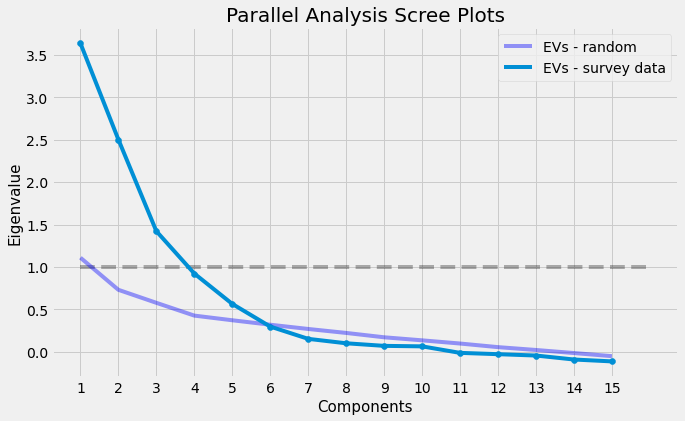

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0015722623846298651
Determinant looks good!
Overall KMO: 0.7917126364395737
All item KMOs are >.6


In [18]:
five_facs = iterative_efa(tss_df, items_analysis_li, n_facs=5, rotation_method="Oblimin", print_details=True,
                          print_par_plot=True)

In [19]:
efa_5 = five_facs[0]
items_5 = five_facs[1]

print_sorted_loadings(efa_5, items_5, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_11   0.674129                                              The story had a clear theme.
tss_coh_3    0.608102                                   The story appeared to be a single plot.
tss_pac_8    0.605947                      All elements of the story were relevant to the plot.
tss_conch_8  0.564228  It was easy to understand the motivation of the characters in the story.
tss_coh_6    0.545650                                     The story felt like a coherent story.
tss_cre_3    0.520729                        The plot development in the story was predictable.
tss_pac_7   -0.459314                  Many things seemed to be happening at once in the story. 

Relevant loadings for factor 1
                  1                                                   descr
tss_pac_3  0.636615  It took a long time for things to happen in the story.
tss_pac_5  0.623

In [20]:
items_per_fac_5 = rev_items_and_return(tss_df, efa_5, items_5)

for factor_n in items_per_fac_5:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...

Internal consistency for factor 0:
Cronbachs alpha = 0.7902, 95% CI = [0.75, 0.83]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.7649
tss_coh_6: 0.7438
tss_coh_11: 0.7553
tss_conch_8: 0.7581
tss_cre_3: 0.7752
tss_pac_8: 0.7653
tss_pac_7_rev: 0.7796


Internal consistency for factor 1:
Cronbachs alpha = 0.7160, 95% CI = [0.66, 0.77]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6813
tss_pac_3: 0.6687
tss_pac_5: 0.6444
tss_pac_1_rev: 0.6643
tss_pac_6_rev: 0.6823


Internal consistency for factor 2:
Cronbachs alpha = 0.7423, 95% CI = [0.69, 0.79]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.6457
tss_rep_9: 0.6279
tss_rep_11: 0.7667
tss_rep_2_rev: 0.6766


Internal consistency for factor 3:
Cronbachs alpha = 0.6678, 95% CI = [0.60, 0.73]

Cronbach's alpha when excluding variable...
tss_cre_12: 0.6569
tss_sty_5: 0.5645
tss_sty_9: 0.6369
tss_sty_11: 0.5399


Internal consistency for factor 4:


In [21]:
items_5_2 = copy.deepcopy(items_5)

items_5_2.remove("tss_rep_11")

items_5_2.extend(["tss_rep_4", "tss_rep_5",
                  "tss_rep_6", "tss_rep_7", "tss_rep_10", "tss_rep_12"])
#items_5_2.extend(["tss_cre_1", "tss_cre_2", "tss_cre_4",
#                  "tss_cre_5", "tss_cre_10", "tss_cre_11"])
#items_5_2.extend(["tss_pac_2", "tss_pac_4"])
#items_5_2.extend(["tss_sty_1", "tss_sty_2", "tss_sty_4", "tss_sty_11"])
items_5_2.extend(["tss_coh_1", "tss_coh_4", "tss_coh_5", "tss_coh_12",
                 "tss_conch_1", "tss_conch_3", "tss_conch_5", "tss_conch_6"])

In [22]:
items_5_2 = reduce_multicoll(
    tss_df, items_5_2, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.519789204972944e-08

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_coh_12. VIF: 24.33
('The story lacked logic.')

Excluded item tss_rep_5. VIF: 21.85
('In the story, the same things happened again and again.')

Excluded item tss_coh_1. VIF: 21.01
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_rep_4. VIF: 19.67
('The story was very repetitive.')

Excluded item tss_conch_5. VIF: 19.39
('The descriptions of characters in the story were plausible.')

Excluded item tss_rep_6. VIF: 18.58
('The writing seemed to use the same words over and over.')

Excluded item tss_conch_3. VIF: 17.38
('My understanding of the characters in the story is unclear.')

Done! Determinant is now: 0.000014
I have excluded 7 redunant items with 28 items remaining


In [23]:
five_facs_2 = iterative_efa(tss_df, items_5_2, n_facs=5, rotation_method="Oblimin", print_details=True,
                            print_par_plot=True)

Fitted solution #1

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 1.3703322776340169e-05
Determinant looks good!
Overall KMO: 0.8511870043541012
All item KMOs are >.6


In [24]:
efa_5_2 = five_facs_2[0]
items_5_2 = five_facs_2[1]

print_sorted_loadings(efa_5_2, items_5_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_4    0.680377                                      The plot of the story was plausible.
tss_coh_11   0.671060                                              The story had a clear theme.
tss_conch_8  0.596752  It was easy to understand the motivation of the characters in the story.
tss_coh_6    0.595508                                     The story felt like a coherent story.
tss_pac_8    0.590053                      All elements of the story were relevant to the plot.
tss_coh_3    0.584862                                   The story appeared to be a single plot.
tss_cre_3    0.564485                        The plot development in the story was predictable.
tss_conch_6 -0.546717         The behavior of characters in the story seemed completely random.
tss_pac_7   -0.459903                  Many things seemed to be happening at once in the story.
tss_coh_5

In [25]:
items_per_fac_5_2 = rev_items_and_return(tss_df, efa_5_2, items_5_2)

for factor_n in items_per_fac_5_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

Internal consistency for factor 0:
Cronbachs alpha = 0.8556, 95% CI = [0.83, 0.88]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8471
tss_coh_6: 0.8303
tss_coh_11: 0.8409
tss_conch_8: 0.8392
tss_cre_3: 0.8494
tss_pac_8: 0.8463
tss_coh_4: 0.8336
tss_coh_5: 0.8424
tss_pac_7_rev: 0.8507
tss_conch_6_rev: 0.8390


Internal consistency for factor 1:
Cronbachs alpha = 0.8766, 95% CI = [0.85, 0.90]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.8550
tss_rep_9: 0.8562
tss_rep_7: 0.8565
tss_rep_10: 0.8432
tss_rep_12: 0.8649
tss_rep_2_rev: 0.8568


Internal consistency for factor 2:
Cronbachs alpha = 0.7160, 95% CI = [0.66, 0.77]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6813
tss_pac_3: 0.6687
tss_pac_5: 0.6444
tss_pac_1_rev: 0.6643
tss_pac_6_rev: 0.6823


Internal consistency for factor 3:
Cronbachs alpha = 0.7935, 95% CI = [0.75, 0.83]

Cronbach's alpha when excluding variable...
tss_conch_2: 0.7392
tss_conch_4: 0.6553
tss_conch_1_rev: 0.7543


Internal co

In [26]:
#items_per_fac_4_2[1].remove("tss_rep_11")
#items_per_fac_4_2[2].remove("tss_cre_9")
items_per_fac_5_2

{0: ['tss_coh_3',
  'tss_coh_6',
  'tss_coh_11',
  'tss_conch_8',
  'tss_cre_3',
  'tss_pac_8',
  'tss_coh_4',
  'tss_coh_5',
  'tss_pac_7_rev',
  'tss_conch_6_rev'],
 1: ['tss_rep_3',
  'tss_rep_9',
  'tss_rep_7',
  'tss_rep_10',
  'tss_rep_12',
  'tss_rep_2_rev'],
 2: ['tss_rep_8', 'tss_pac_3', 'tss_pac_5', 'tss_pac_1_rev', 'tss_pac_6_rev'],
 3: ['tss_conch_2', 'tss_conch_4', 'tss_conch_1_rev'],
 4: ['tss_cre_12', 'tss_sty_5', 'tss_sty_9', 'tss_sty_11']}

In [27]:
# compute scale means but only if at least 66% of questions are answered
mask_suff_data_coh = tss_df[items_per_fac_5_2[0]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[0])/3)
mask_suff_data_rep = tss_df[items_per_fac_5_2[1]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[1])/3)
mask_suff_data_pac = tss_df[items_per_fac_5_2[2]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[2])/3)
mask_suff_data_conch = tss_df[items_per_fac_5_2[3]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[3])/3)
mask_suff_data_cre = tss_df[items_per_fac_5_2[4]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[4])/3)

tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_5_2[0]].mean(
    axis=1)
tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_5_2[1]].mean(
    axis=1)
tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_5_2[2]].mean(
    axis=1)
tss_df["tss_conch"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[3]].mean(
    axis=1)
tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[4]].mean(
    axis=1)

# Some scales might make more sense fully reversed
tss_df["tss_pac"] = (tss_df["tss_pac"]-6)*-1
tss_df["tss_conch"] = (tss_df["tss_conch"]-6)*-1
tss_df["tss_avoid_rep"] = (tss_df["tss_rep"]-6)*-1

In [28]:
# if you actually have missing data, double check if this worked as intended
tss_df[~mask_suff_data_cre]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,tss_pac_6_rev,tss_rep_2_rev,tss_conch_6_rev,tss_conch_1_rev,tss_coh,tss_rep,tss_pac,tss_conch,tss_cre,tss_avoid_rep


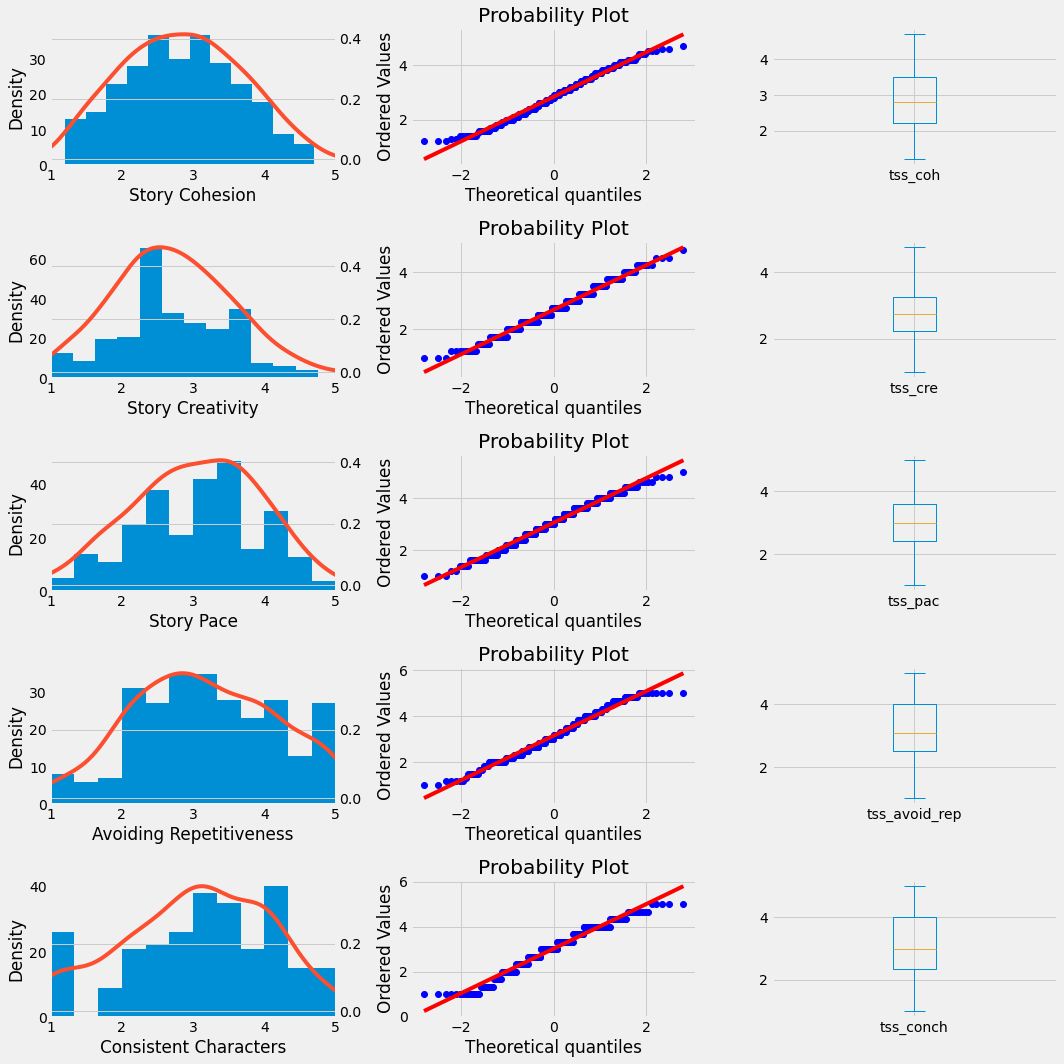

In [32]:
# Check scale distributions
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
ax1.set_xlim(1, 5)
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
ax2.set_xlim(1, 5)
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")
ax3.set_xlim(1, 5)

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Avoiding Repetitiveness")
ax4.set_xlim(1, 5)

ax5 = tss_df["tss_conch"].plot.hist(ax=axes[4, 0], bins=12)
tss_df["tss_conch"].plot.kde(ax=axes[4, 0], secondary_y=True)
ax5.set_xlabel("Consistent Characters")
ax5.set_xlim(1, 5)

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])
stats.probplot(tss_df["tss_conch"], dist="norm", plot=axes[4, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])
tss_df["tss_conch"].plot.box(ax=axes[4, 2])

fig.tight_layout()
plt.show()

In [33]:
tss_df[["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]].corr()

,tss_coh,tss_cre,tss_avoid_rep,tss_pac,tss_conch
tss_coh,1.000000,0.182343,0.165261,-0.105217,0.471619
tss_cre,0.182343,1.000000,0.204166,0.210376,0.204524
tss_avoid_rep,0.165261,0.204166,1.000000,0.220800,0.202427
tss_pac,-0.105217,0.210376,0.220800,1.000000,0.017019
tss_conch,0.471619,0.204524,0.202427,0.017019,1.000000


<Figure size 720x720 with 0 Axes>

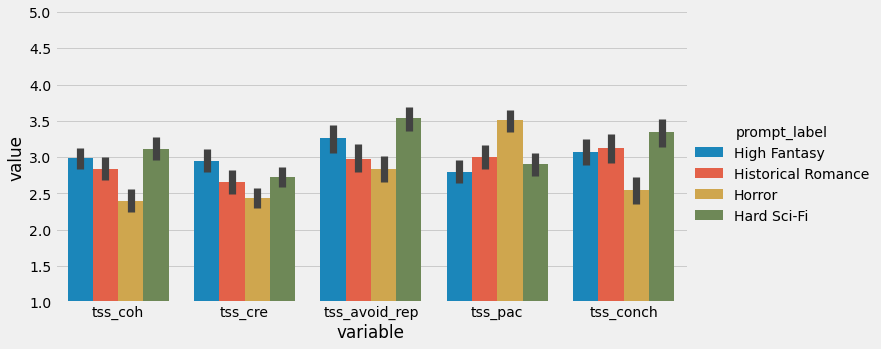

In [34]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<Figure size 720x720 with 0 Axes>

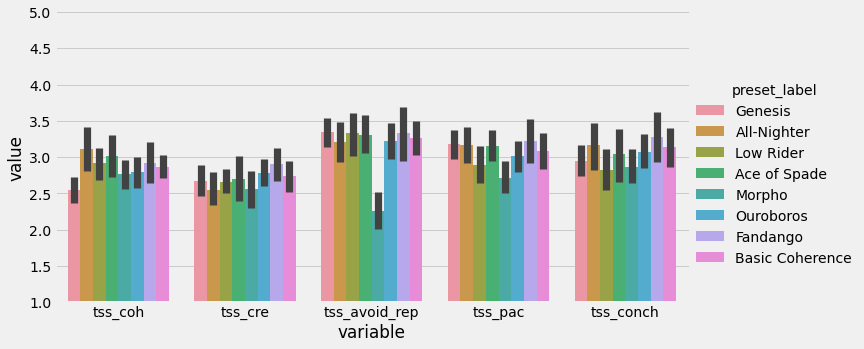

In [35]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<AxesSubplot:xlabel='word_count', ylabel='tss_conch'>

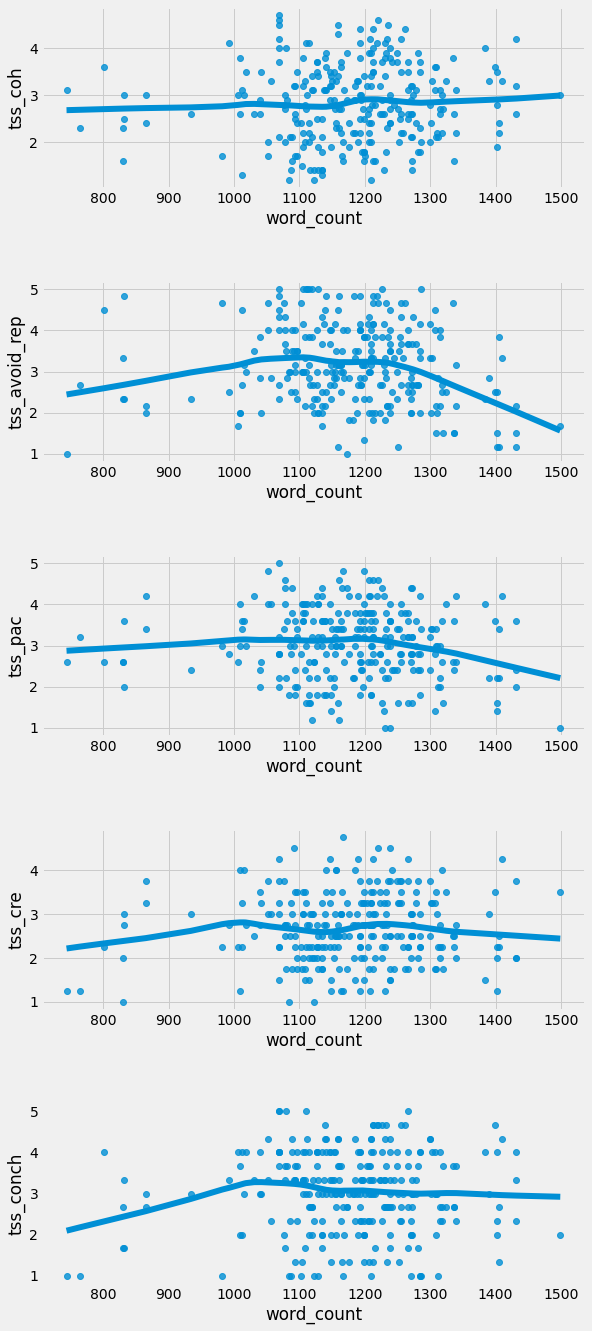

In [44]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[2])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[3])
sns.regplot(data=tss_df, y="tss_conch",
            x="word_count", lowess=True, ax=axes[4])

In [45]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA

Model performance for linear model predicting tss_coh:
r-square: -0.0130    RMSE: 0.8110
Model performance for quadratic model predicting tss_coh:
r-square: -0.0169    RMSE: 0.8126
Model performance for cubic model predicting tss_coh:
r-square: -0.0198    RMSE: 0.8136

Model performance for linear model predicting tss_cre:
r-square: -0.0526    RMSE: 0.7752
Model performance for quadratic model predicting tss_cre:
r-square: -0.0598    RMSE: 0.7773
Model performance for cubic model predicting tss_cre:
r-square: -0.0646    RMSE: 0.7785

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0241    RMSE: 0.9593
Model performance for quadratic model predicting tss_avoid_rep:
r-square: 0.0253    RMSE: 0.9314
Model performance for cubic model predicting tss_avoid_rep:
r-square: 0.0132    RMSE: 0.9392

Model performance for linear model predicting tss_pac:
r-square: -0.0545    RMSE: 0.8530
Model performance for quadratic model predicting tss_pac:
r-square: -0.0490    RMSE: 

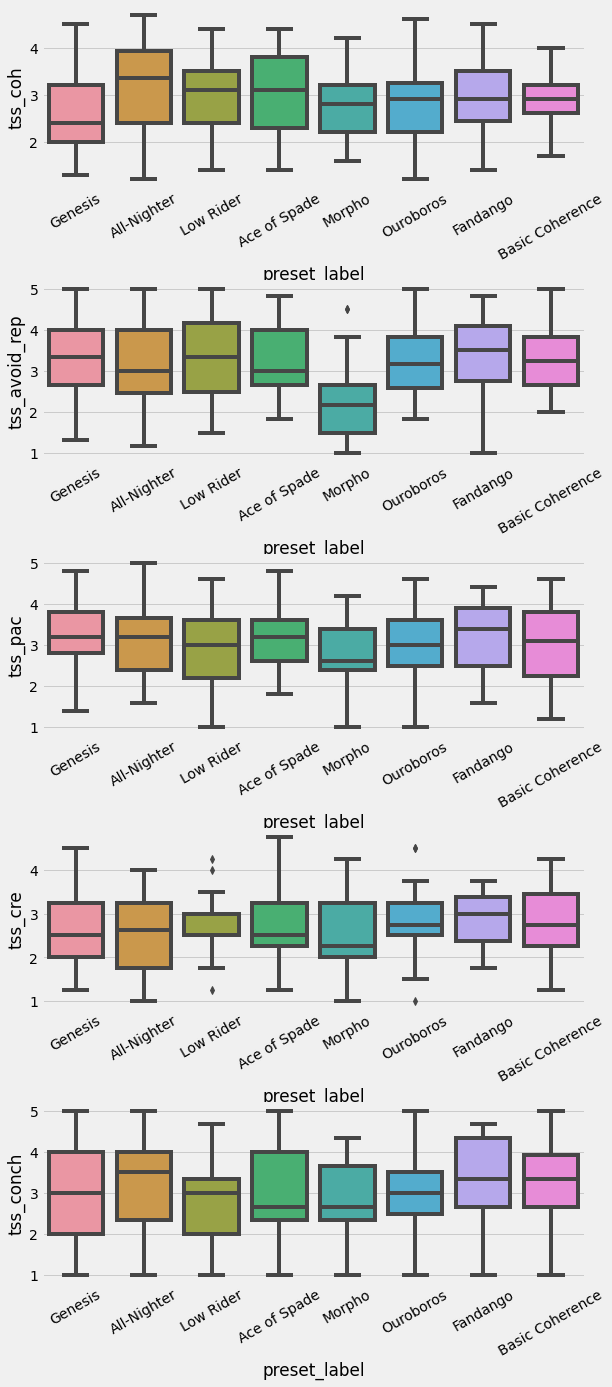

In [54]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="preset_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

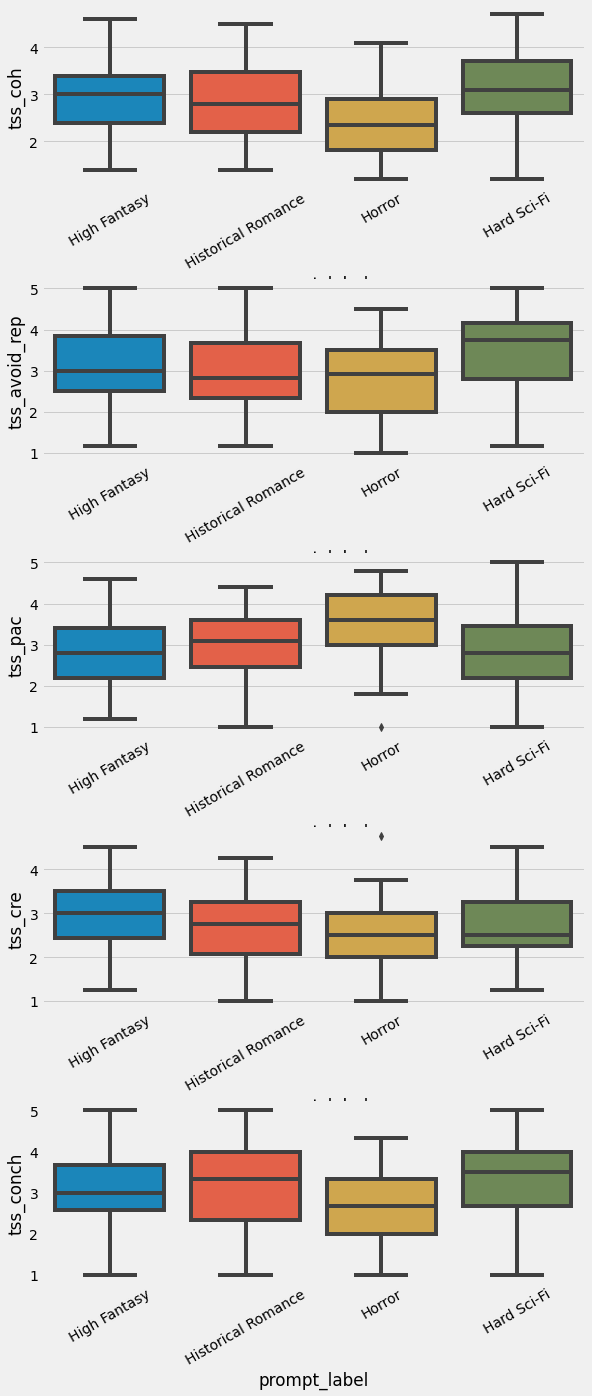

In [57]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="prompt_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [58]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)

    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(
            q1, q3, iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")

In [59]:
# Outliers for Presets

# # Outliers Coherence
# print("Exterme outliers on tss_coh, Ouroboros preset")
# determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_coh")

# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_avoid_rep")

# # Outliers pace
# print("\nExterme outliers on tss_pac, Ace of Spades preset")
# determine_outliers(tss_df[tss_df["preset_label"] == "Ace of Spades"], "tss_pac")
# print("\nExterme outliers on tss_pac, Ouroboros preset")
# determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_pac")

# Outliers creativity
print("\nExterme outliers on tss_cre, Low Rider preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Low Rider"], "tss_cre")
print("\nExterme outliers on tss_pac, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_cre")

## Outliers for Prompts

# # Coherence
# print("\nExterme outliers on tss_coh, Hard Sci-Fi prompt")
# determine_outliers(tss_df[tss_df["prompt_label"] == "Hard Sci-Fi"], "tss_coh")
# # Pace
# print("\nExterme outliers on tss_pac, Horror prompt")
# determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_pac")

# Creativity
print("\nExterme outliers on tss_cre, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_cre")


Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): 1.50
75th Percentile (Q3): 2.67
IQR: 1.17
Will count cases as outlier with values less than -2.00 or more than 6.17.
With these criteria there are no outlier in the data

Exterme outliers on tss_cre, Low Rider preset
25th Percentile (Q1): 2.50
75th Percentile (Q3): 3.00
IQR: 0.50
Will count cases as outlier with values less than 1.00 or more than 4.50.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ouroboros preset
25th Percentile (Q1): 2.50
75th Percentile (Q3): 3.25
IQR: 0.75
Will count cases as outlier with values less than 0.25 or more than 5.50.
With these criteria there are no outlier in the data

Exterme outliers on tss_cre, Horror prompt
25th Percentile (Q1): 2.00
75th Percentile (Q3): 3.00
IQR: 1.00
Will count cases as outlier with values less than -1.00 or more than 6.00.
With these criteria there are no outlier in the data


In [60]:
#tss_no_out = tss_df[~(tss_df.index == 7)].copy()
tss_no_out = tss_df

In [61]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15, 15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(vars_li), len(groups_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li, vars_li):
        stats.probplot(df[df[group_label] == group][var],
                       dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - " + var)
        if x < (len(groups_li)-1):
            x += 1
        else:
            x = 0
            y += 1

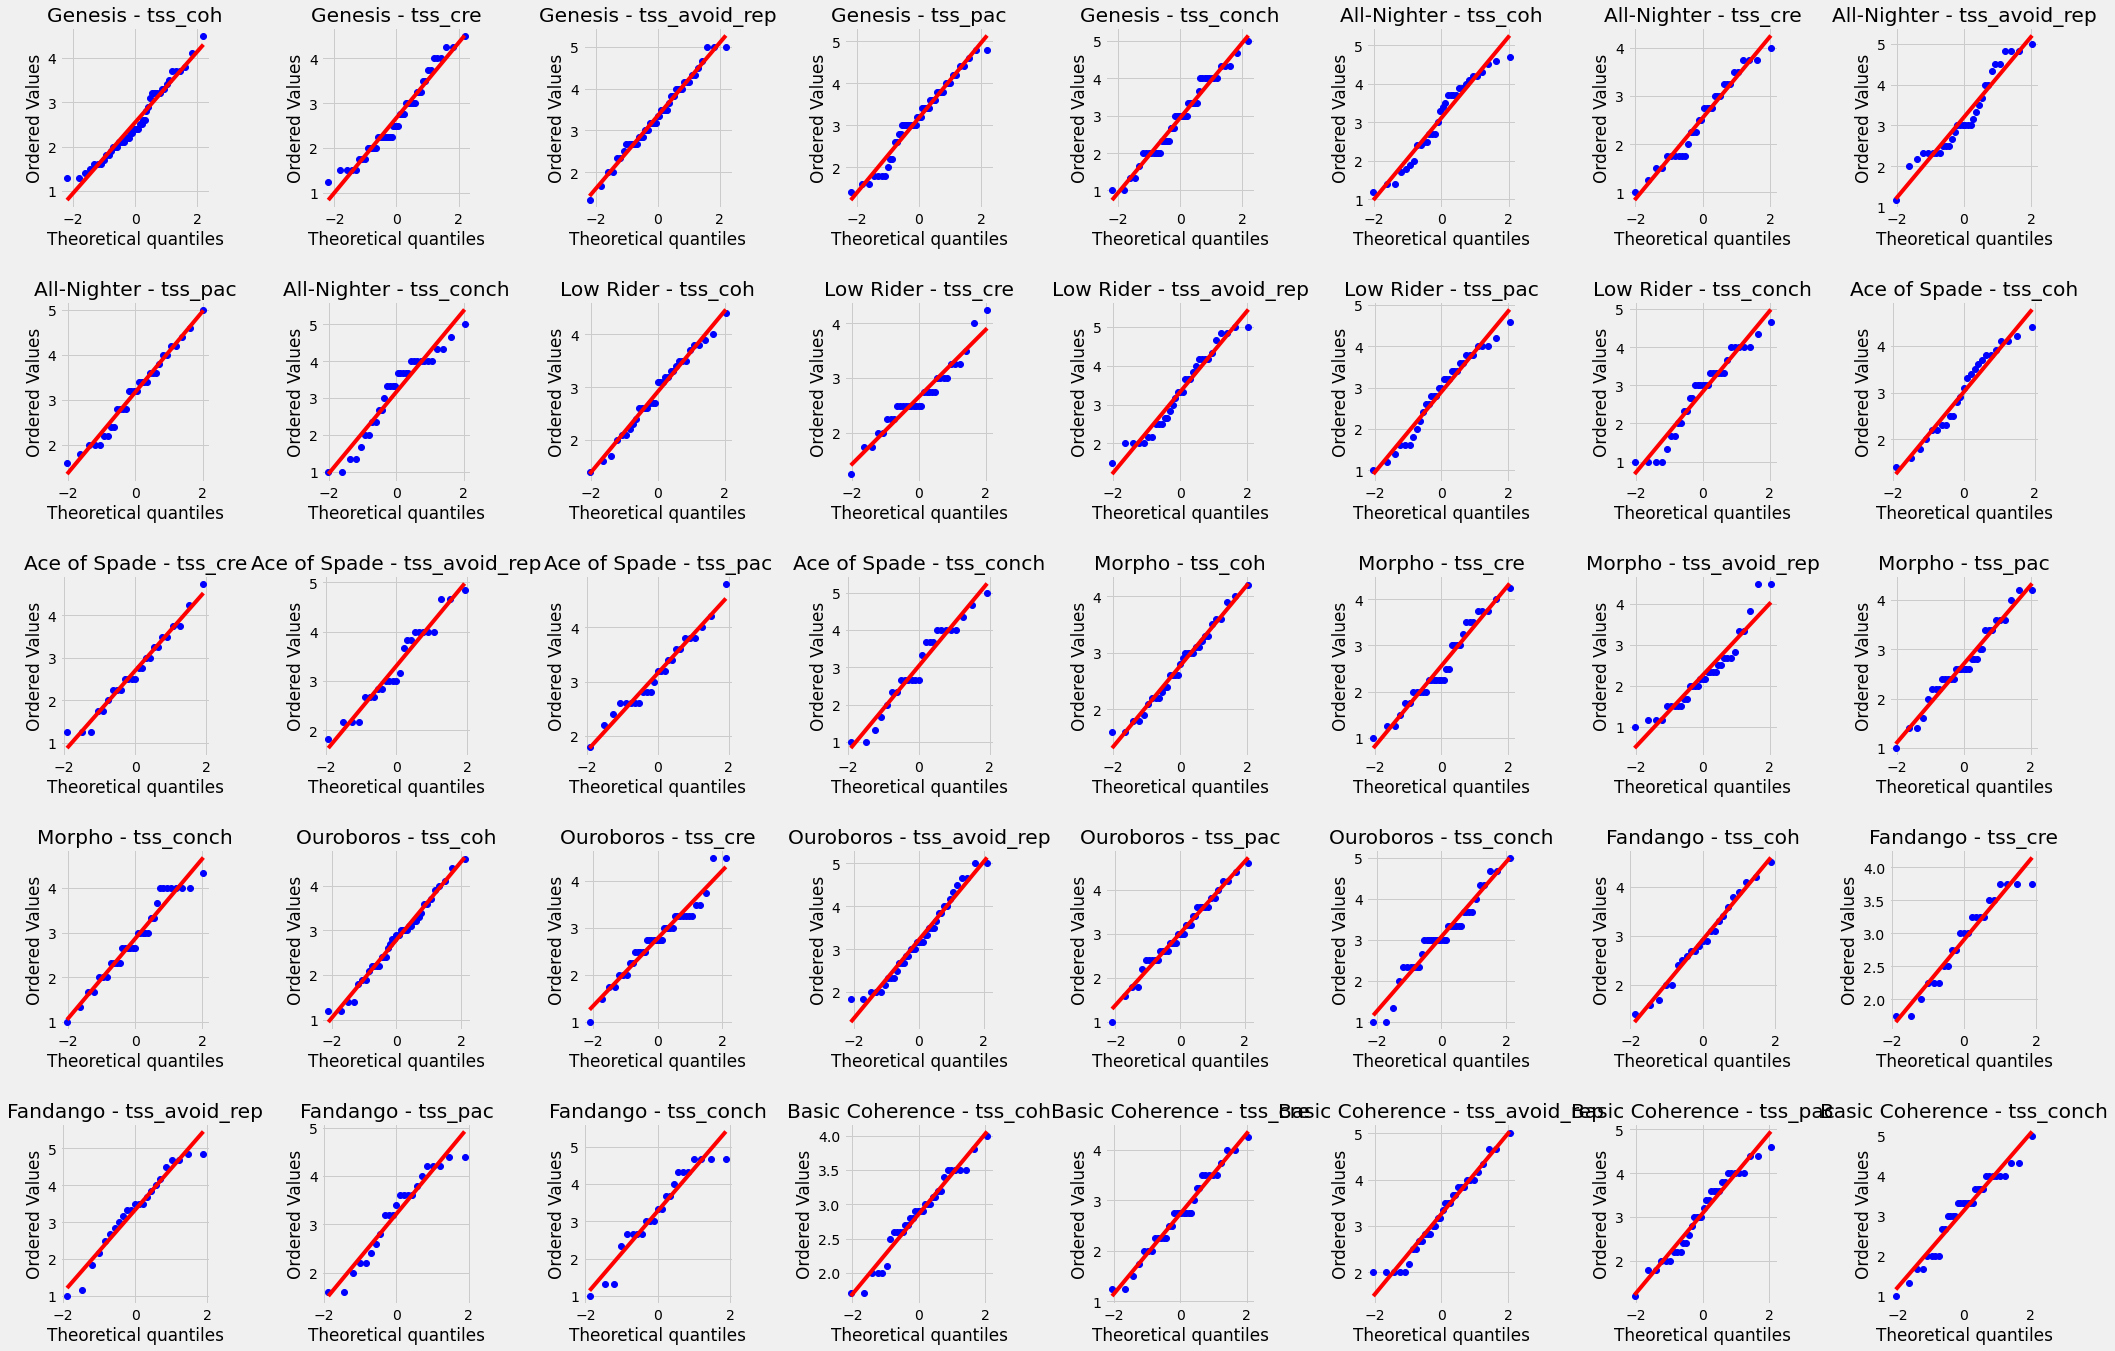

In [63]:
qqs_over_groups_and_vars(tss_no_out, "preset_label", outcome_li, size=(30, 20))

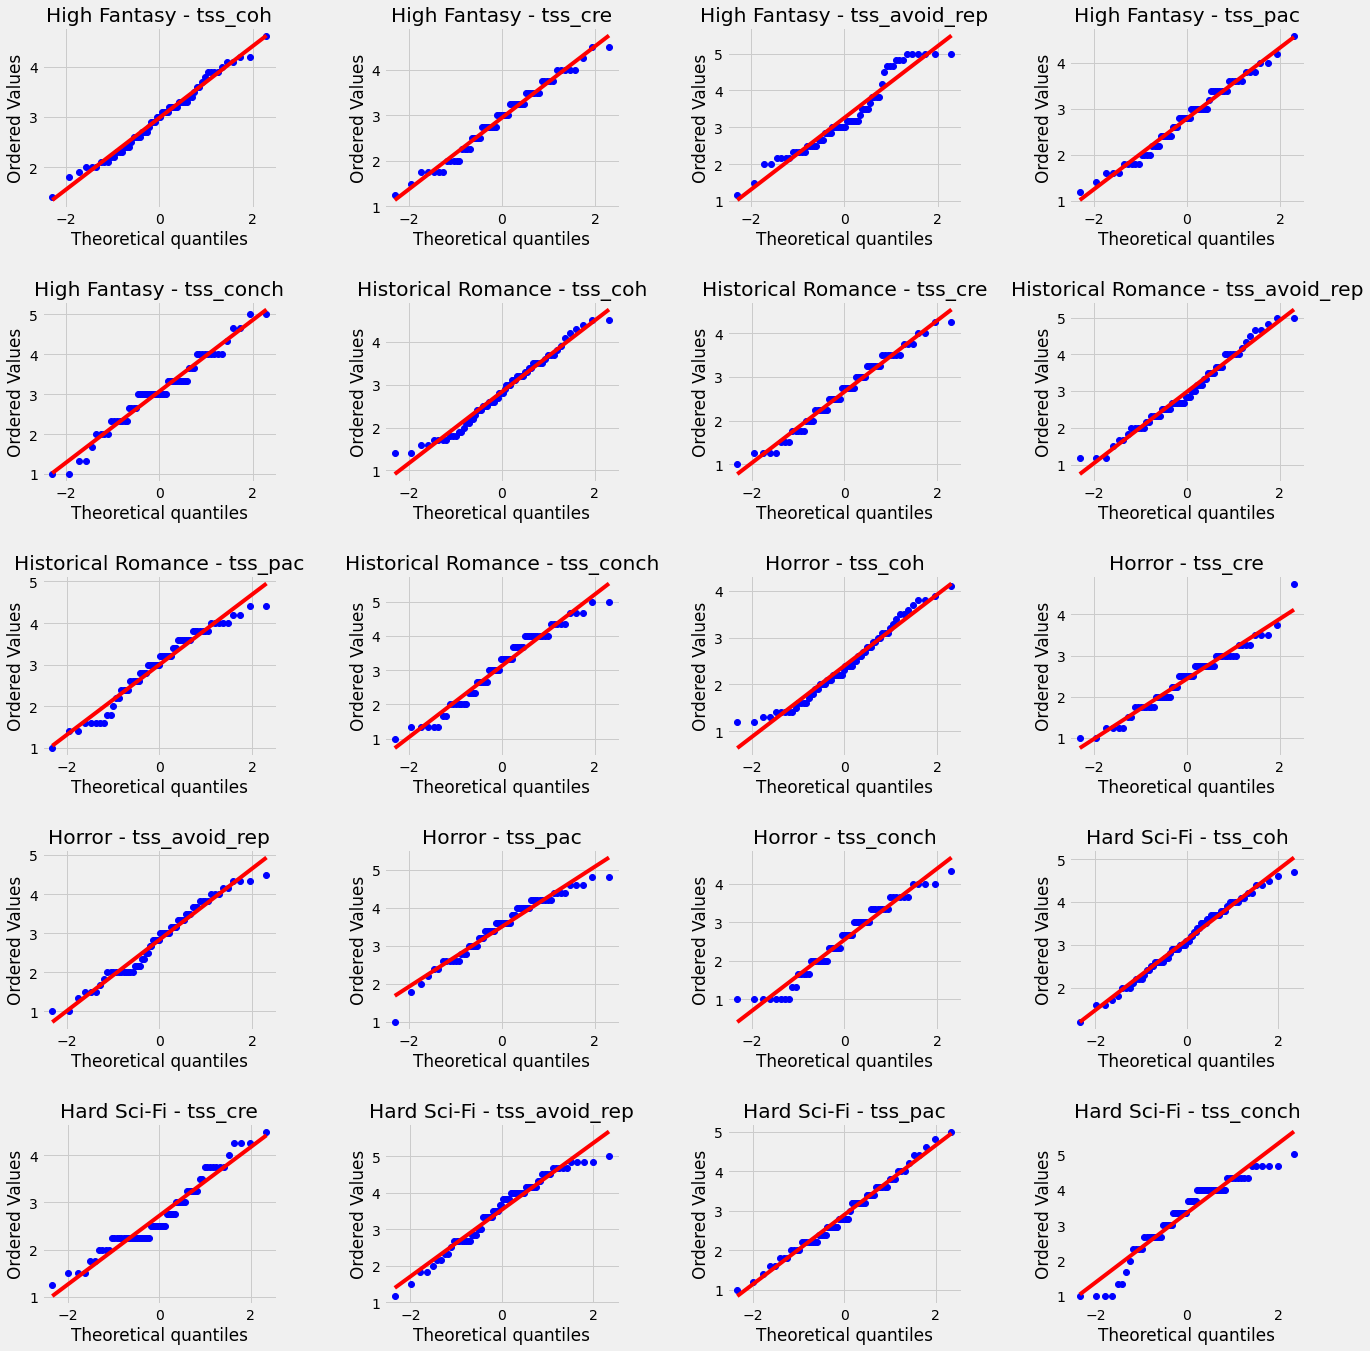

In [64]:
qqs_over_groups_and_vars(tss_no_out, "prompt_label", outcome_li, size=(20, 20))

In [65]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {}, coefficient of sample size variation is {:.2f}, variance ratio is {}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")

In [66]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_no_out)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_no_out)
    print("\n")

Checks for tss_coh
Preset
Smallest variance for Basic Coherence: 0.33
Largest variance for All-Nighter: 1.07
Variance ratio for: 3.26
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.21. That is below 0 or over .5. Continuing with further checks...
Pairing is -0.21, so smaller than 0 and larger than or equal to -.5, ,coefficient of sample size variation is 0.34, larger than .16, and variance ratio is 3.26, larger than 2. F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).

Prompt
Smallest variance for High Fantasy: 0.49
Largest variance for Historical Romance: 0.68
Variance ratio for: 1.37
Variance ratio is smaller or equal to 1.5, F-test will be robust.


Checks for tss_cre
Preset
Smallest variance for Low Rider: 0.37
Largest variance for Ace of Spade: 0.84
Variance ratio for: 2.28
Variance ratio is larger 1.5. Now doing additional checks to see if

In [67]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_no_out).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, tss_no_out).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]

tss_coh
                             sum_sq     df          F    PR(>F)
C(preset_label, Sum)       6.028219    7.0   1.453823  0.184277
C(prompt_label, Sum)      18.671399    3.0  10.506937  0.000002
C(sample, Treatment(0))    0.000364    1.0   0.000615  0.980233
Residual                 151.641977  256.0        NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_coh   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     4.649
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           1.80e-06
Time:                        09:30:35   Log-Likelihood:                -303.97
No. Observations:                 268   AIC:                             631.9
Df Residuals:                     256   BIC:                             675.0
Df Model:                          11   

In [68]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_no_out["preset_label"].unique())
prompts_li = list(tss_no_out["prompt_label"].unique())

order_index = ["Intercept"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]

In [69]:
params_df

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Intercept,2.858479,0.000000e+00,NaN,0.110442,2.567053,0.000000,NaN,0.105872,3.332554,0.000000e+00,NaN,0.136325,3.110969,0.000000e+00,NaN,0.115906,2.963073,1.012091e-222,NaN,0.152985
Genesis,-0.302509,4.787178e-03,3.829743e-02,0.176384,-0.029515,0.790942,0.903933,0.183136,0.220584,6.428829e-02,2.571532e-01,0.196105,0.114227,3.144010e-01,5.101165e-01,0.186760,-0.067665,6.276222e-01,0.878691,0.229445
All-Nighter,0.208334,1.975333e-01,7.901331e-01,0.265929,-0.138155,0.269654,0.843621,0.205864,-0.021908,8.847172e-01,8.847172e-01,0.248538,0.137064,3.597598e-01,5.101165e-01,0.246173,0.079724,6.590185e-01,0.878691,0.297174
Low Rider,0.060397,6.460004e-01,8.613339e-01,0.216283,-0.036475,0.733763,0.903933,0.176397,0.178863,2.360173e-01,6.010167e-01,0.248272,-0.167131,2.880028e-01,5.101165e-01,0.258732,-0.186709,2.560610e-01,0.878691,0.270401
Ace of Spade,0.142851,3.130469e-01,8.347917e-01,0.232908,0.017310,0.914379,0.914379,0.264825,0.127588,4.262007e-01,6.010167e-01,0.263744,0.098974,3.825873e-01,5.101165e-01,0.186451,-0.010102,9.590497e-01,0.959050,0.323603
Morpho,-0.079661,5.051644e-01,8.365258e-01,0.196629,-0.138523,0.316358,0.843621,0.227403,-0.867943,5.118387e-10,4.094710e-09,0.229693,-0.348080,7.313937e-03,5.851150e-02,0.213459,-0.151543,3.016620e-01,0.878691,0.241332
Ouroboros,-0.076437,5.228286e-01,8.365258e-01,0.196760,0.061503,0.565153,0.903933,0.175873,0.084381,5.278142e-01,6.032163e-01,0.219839,-0.033220,7.937322e-01,8.680758e-01,0.208983,0.031465,8.206850e-01,0.937926,0.228333
Fandango,0.032418,8.515282e-01,8.819229e-01,0.284890,0.219336,0.116246,0.843621,0.229687,0.149654,4.507625e-01,6.010167e-01,0.326409,0.176462,2.628913e-01,5.101165e-01,0.259252,0.189539,3.714001e-01,0.878691,0.348786
Basic Coherence,0.014607,8.819229e-01,8.819229e-01,0.161761,0.044519,0.720695,0.903933,0.204817,0.128781,3.472474e-01,6.010167e-01,0.225361,0.021704,8.680758e-01,8.680758e-01,0.214922,0.115291,4.532756e-01,0.878691,0.252860
High Fantasy,0.168410,3.962944e-02,5.283926e-02,0.134628,0.259369,0.002189,0.004378,0.139268,0.123127,1.955456e-01,1.955456e-01,0.156470,-0.240763,5.408040e-03,1.081608e-02,0.142368,0.065483,5.203285e-01,0.520328,0.167554


In [86]:
adj_p_cols = params_df.columns.str.extractall("(.*adj_p)").values.flatten()
mask_sig = (params_df[adj_p_cols] < 0.1).any(axis = 1)

params_df[mask_sig]

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Genesis,-0.302509,4.787178e-03,3.829743e-02,0.176384,-0.029515,0.790942,0.903933,0.183136,0.220584,6.428829e-02,2.571532e-01,0.196105,0.114227,3.144010e-01,5.101165e-01,0.186760,-0.067665,0.627622,0.878691,0.229445
Morpho,-0.079661,5.051644e-01,8.365258e-01,0.196629,-0.138523,0.316358,0.843621,0.227403,-0.867943,5.118387e-10,4.094710e-09,0.229693,-0.348080,7.313937e-03,5.851150e-02,0.213459,-0.151543,0.301662,0.878691,0.241332
High Fantasy,0.168410,3.962944e-02,5.283926e-02,0.134628,0.259369,0.002189,0.004378,0.139268,0.123127,1.955456e-01,1.955456e-01,0.156470,-0.240763,5.408040e-03,1.081608e-02,0.142368,0.065483,0.520328,0.520328,0.167554
Horror,-0.424933,2.186368e-07,8.745474e-07,0.134861,-0.261121,0.000960,0.003842,0.130080,-0.319525,4.961154e-04,9.922307e-04,0.150903,0.463371,4.192016e-08,1.676806e-07,0.139018,-0.473540,0.000002,0.000009,0.164932
Hard Sci-Fi,0.254516,1.830925e-03,3.661851e-03,0.134336,0.029758,0.710271,0.737422,0.131761,0.339492,3.170710e-04,9.922307e-04,0.155075,-0.180499,5.939201e-02,7.918935e-02,0.157480,0.304967,0.004756,0.009511,0.177684


In [87]:
tss_no_out["preset_label"].value_counts()

Genesis            49
Ouroboros          39
Basic Coherence    34
Low Rider          33
Morpho             33
All-Nighter        32
Ace of Spade       25
Fandango           23
Name: preset_label, dtype: int64

In [ ]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")

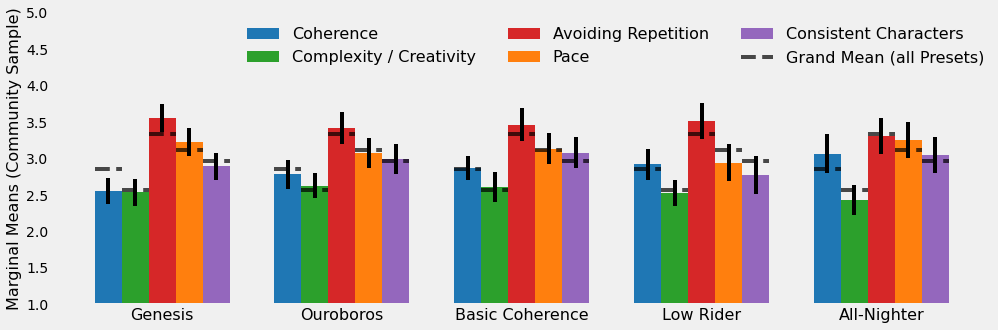

In [113]:
labels = ["Coherence", "Complexity / Creativity", "Avoiding Repitition", "Pace", "Consistent Characters"]

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}

prod_presets_outcomes = itertools.product(
    ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter"],
    outcome_li)

for preset, outcome in prod_presets_outcomes:
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
    yerr_dict[outcome].append(
        params_df.loc[preset, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(15, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.15  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.15, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Complexity / Creativity", color="tab:green")

plt.bar(x, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.15, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.bar(x+0.3, marginal_means_dict["tss_conch"], width,
        yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter"],
           fontsize=16)

outcome_i = 0
pos = -0.375
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 5, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")

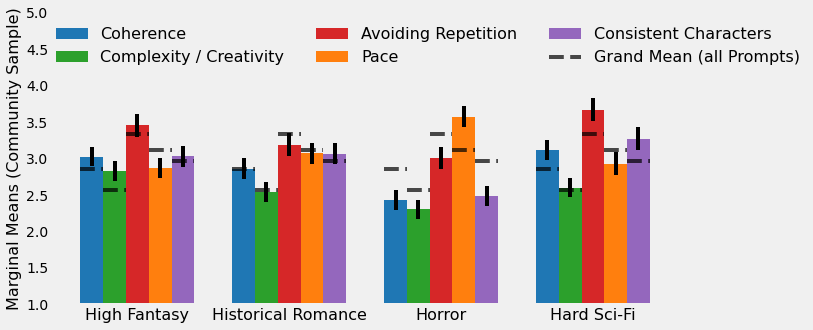

In [117]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.15  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.15, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Complexity / Creativity", color="tab:green")

plt.bar(x, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.15, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.bar(x+0.3, marginal_means_dict["tss_conch"], width,
        yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

outcome_i = 0
pos = -0.375
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Prompts)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 5, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")

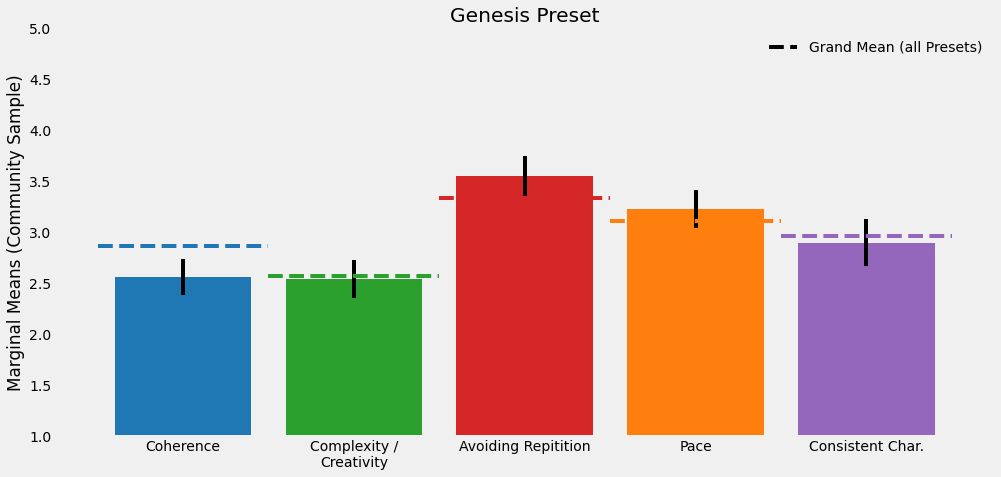

In [122]:
genesis_marginal_means = []
genesis_yerr = []
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange", "tab:purple"]

for outcome in outcome_li:
    genesis_marginal_means.append(
        params_df.loc["Intercept", outcome] + params_df.loc["Genesis", outcome])
    genesis_yerr.append(params_df.loc["Genesis", outcome + " 90% CI margin"])


figure = plt.figure(figsize=(15, 7))

plt.bar(["Coherence", "Complexity /\nCreativity", "Avoiding Repitition", "Pace", "Consistent Char."],
        genesis_marginal_means, yerr=genesis_yerr,
        color=colors)

i = 0
pos = -0.5
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+1], [grand_mean, grand_mean],
                  '--', color=colors[i])
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)")

plt.legend(frameon=False)
leg = plt.gca().get_legend()
leg.legendHandles[0].set_color('black')
plt.grid(False)
plt.title("Genesis Preset")
plt.show()
figure.savefig('graphs/genesis.png', bbox_inches="tight")

In [123]:
tss_no_out[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre", "tss_conch",
            "tss_cre_4",
            "tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]].corr(method="kendall")

,tss_coh,tss_avoid_rep,tss_pac,tss_cre,tss_conch,tss_cre_4,tss_qua_1,tss_qua_2,tss_qua_3,tss_qua_5,tss_qua_6,tss_qua_7,tss_qua_8
tss_coh,1.000000,0.098504,-0.080805,0.120920,0.355486,0.072893,0.340906,0.377789,0.278864,0.233046,0.399282,0.355728,0.406166
tss_avoid_rep,0.098504,1.000000,0.168366,0.130092,0.167044,0.168263,0.207436,0.218752,0.197159,0.169260,0.175359,0.201759,0.200457
tss_pac,-0.080805,0.168366,1.000000,0.143174,0.006430,0.282798,0.168982,0.067673,0.262738,0.209717,0.123154,0.107790,0.047450
tss_cre,0.120920,0.130092,0.143174,1.000000,0.115988,0.394742,0.360587,0.436231,0.400982,0.472939,0.414519,0.380854,0.428639
tss_conch,0.355486,0.167044,0.006430,0.115988,1.000000,0.168222,0.231558,0.270377,0.197095,0.218970,0.234660,0.148027,0.272467
tss_cre_4,0.072893,0.168263,0.282798,0.394742,0.168222,1.000000,0.375203,0.302418,0.391334,0.372748,0.359067,0.297669,0.299193
tss_qua_1,0.340906,0.207436,0.168982,0.360587,0.231558,0.375203,1.000000,0.506361,0.701031,0.381837,0.691413,0.585269,0.498817
tss_qua_2,0.377789,0.218752,0.067673,0.436231,0.270377,0.302418,0.506361,1.000000,0.503359,0.449603,0.580809,0.577443,0.667175
tss_qua_3,0.278864,0.197159,0.262738,0.400982,0.197095,0.391334,0.701031,0.503359,1.000000,0.408657,0.703642,0.592573,0.498230
tss_qua_5,0.233046,0.169260,0.209717,0.472939,0.218970,0.372748,0.381837,0.449603,0.408657,1.000000,0.363076,0.364150,0.429589


In [ ]:
items_descr[["tss_cre_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]

In [124]:
tss_no_out["qual_2_agree+"] = tss_no_out["tss_qua_2"].apply(
    lambda x: 1 if x >= 4 else 0)
tss_no_out["qual_1_agree+"] = tss_no_out["tss_qua_1"].apply(
    lambda x: 1 if x >= 4 else 0)

In [125]:
# Center preds and prepare polynomial arrays
unc_pred_names_li = ["word_count", "tss_coh",
                     "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
cent_pred_names_li = []

# Defining predictors for models
for pred in unc_pred_names_li:
    cent_pred = pred + "_cent"
    tss_no_out[cent_pred] = tss_no_out[pred].apply(
        lambda x: x-tss_no_out[pred].mean())  # centering
    cent_pred_names_li.append(cent_pred)

lin_pred_data = tss_no_out[cent_pred_names_li].to_numpy()

poly_lin = polyfeat(interaction_only=True, include_bias=False)
lin_int_pred_data = poly_lin.fit_transform(lin_pred_data)

quad_pred_data = np.hstack((lin_pred_data, lin_pred_data**2))
cub_pred_data = np.hstack((lin_pred_data, lin_pred_data**2, lin_pred_data**3))
quart_pred_data = np.hstack(
    (lin_pred_data, lin_pred_data**2, lin_pred_data**3, lin_pred_data**4))

# Setting up k-fold cross validation
kf = KFold(10, shuffle=True, random_state=42)

log_model = logreg(max_iter=1000)

# setup list of model names with predictor arrays
poly_preds_li = [("linear", lin_pred_data), ("linear with interactions", lin_int_pred_data),
                 ("quadratic", quad_pred_data),
                 ("cubic", cub_pred_data), ("quartic", quart_pred_data)]

qua_li = ["qual_1_agree+", "qual_2_agree+"]

for qual_measure in qua_li:
    for poly_pred in poly_preds_li:
        y = tss_no_out[qual_measure]
        current_pred = poly_pred[1]
        current_model_name = poly_pred[0]
        cross_val = cross_validate(log_model, current_pred, y,
                                   scoring=["neg_log_loss"], cv=kf)
        # get negative loss scores, throw out nans if we got some
        nll = cross_val["test_neg_log_loss"]
        nll = nll[~np.isnan(nll)]
        avg_nll = np.mean(nll)
        print("Model performance for {} model predicting good or better output for {}:".format(
            current_model_name, qual_measure))
        print("negative log loss:{:.4f}\n".format(avg_nll))
    print("")

    # linear without interactions performs best

Model performance for linear model predicting good or better output for qual_1_agree+:
negative log loss:-0.5118

Model performance for linear with interactions model predicting good or better output for qual_1_agree+:
negative log loss:-0.5441

Model performance for quadratic model predicting good or better output for qual_1_agree+:
negative log loss:-0.5346

Model performance for cubic model predicting good or better output for qual_1_agree+:
negative log loss:-0.6736

Model performance for quartic model predicting good or better output for qual_1_agree+:
negative log loss:-0.6744


Model performance for linear model predicting good or better output for qual_2_agree+:
negative log loss:-0.3071

Model performance for linear with interactions model predicting good or better output for qual_2_agree+:
negative log loss:-0.3826

Model performance for quadratic model predicting good or better output for qual_2_agree+:
negative log loss:-0.3250

Model performance for cubic model predicting 

In [130]:
log_reg_q1 = smf.logit(("Q('qual_1_agree+') ~ word_count_cent + tss_coh_cent" +
                     "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                        "+ tss_conch_cent" +
                       "+ C(sample, Treatment(0))"),
                    data=tss_no_out).fit()
log_reg_q2 = smf.logit(("Q('qual_2_agree+') ~ word_count_cent + tss_coh_cent" +
                     "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                         "+ tss_conch_cent" +
                       "+ C(sample, Treatment(0))"),
                    data=tss_no_out).fit()

print("\n\033[1mQuality Item 1 (Enjoyment)\033[0m")
print(log_reg_q1.summary())
print("\n\033[1mQuality Item 2 (High Quality)\033[0m")
print(log_reg_q2.summary())

Optimization terminated successfully.
         Current function value: 0.486793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.279323
         Iterations 8

Quality Item 1 (Enjoyment)
                           Logit Regression Results                           
Dep. Variable:     Q('qual_1_agree+')   No. Observations:                  268
Model:                          Logit   Df Residuals:                      260
Method:                           MLE   Df Model:                            7
Date:                Wed, 06 Apr 2022   Pseudo R-squ.:                  0.2586
Time:                        10:14:08   Log-Likelihood:                -130.46
converged:                       True   LL-Null:                       -175.97
Covariance Type:            nonrobust   LLR p-value:                 7.627e-17
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [131]:
logreg_li = [("Quality 1 (Enjoyment)", log_reg_q1), ("Quality 2 (High Quality)", log_reg_q2)]

for log_reg in logreg_li:
    print(f"Predictions & Performance for {log_reg[0]}")
    pred_table = log_reg[1].pred_table()

    # read out table values
    tn = pred_table[0, 0]
    tp = pred_table[1, 1]
    fn = pred_table[1, 0]
    fp = pred_table[0, 1]
    total = np.sum(pred_table)

    # Observed Probability
    obs_p = (tp + fn) / total

    # predicted prob
    pred_prob = (tp + fp) / total

    # Accuracy: Correct classification over all cases
    acc = (tp + tn) / total

    # Precision: Accuracy for data predicted to be positive
    prec = tp / (tp+fp)
    # Recall: Accuracy for positive (enjoyable/high quality) data
    rec = tp / (tp+fn)
    
    odds_ratio = np.exp(log_reg[1].params)

    print(f"Observed Probability: {obs_p:.2f}\n"
          f"Predicted Probability: {pred_prob:.2f}\n\n"
          f"Model Performance\n"
          f"Accuracy: {acc:.2f}\n"
          f"Precision: {prec:.2f}\n"
          f"Recall: {rec:.2f}\n"
          f"\nOdds Ratio:\n{odds_ratio}\n")

Predictions & Performance for Quality 1 (Enjoyment)
Observed Probability: 0.37
Predicted Probability: 0.29

Model Performance
Accuracy: 0.75
Precision: 0.71
Recall: 0.56

Odds Ratio:
Intercept                           0.353997
C(sample, Treatment(0))[T.Panel]    1.693015
word_count_cent                     1.003055
tss_coh_cent                        2.555521
tss_cre_cent                        2.431990
tss_avoid_rep_cent                  1.446594
tss_pac_cent                        1.961395
tss_conch_cent                      1.401434
dtype: float64

Predictions & Performance for Quality 2 (High Quality)
Observed Probability: 0.16
Predicted Probability: 0.08

Model Performance
Accuracy: 0.88
Precision: 0.71
Recall: 0.36

Odds Ratio:
Intercept                           0.055315
C(sample, Treatment(0))[T.Panel]    1.474273
word_count_cent                     1.002243
tss_coh_cent                        3.045158
tss_cre_cent                        4.414873
tss_avoid_rep_cent            

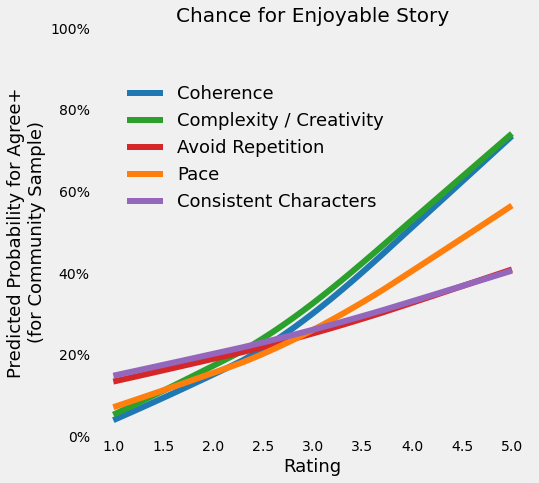

In [134]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent", "tss_conch_cent",
                  "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh", "tab:blue"),
             ("Complexity / Creativity", "tss_cre", "tab:green"),
            ("Avoid Repetition", "tss_avoid_rep", "tab:red"),
             ("Pace", "tss_pac", "tab:orange"),
            ("Consistent Characters", "tss_conch", "tab:purple")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    color = var[2]
    pred_df.rename(columns = {"plot_values": var_full}, inplace = True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 1"] = log_reg_q1.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 1",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True, color = color)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+\n(for Community Sample)")
plt.xlabel("Rating")
ax.legend(fontsize=18, frameon = False, bbox_to_anchor = (.7,.9))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Chance for Enjoyable Story", fontsize=20)
plt.savefig("graphs/logreg_qual_1.png", bbox_inches="tight")
plt.show()

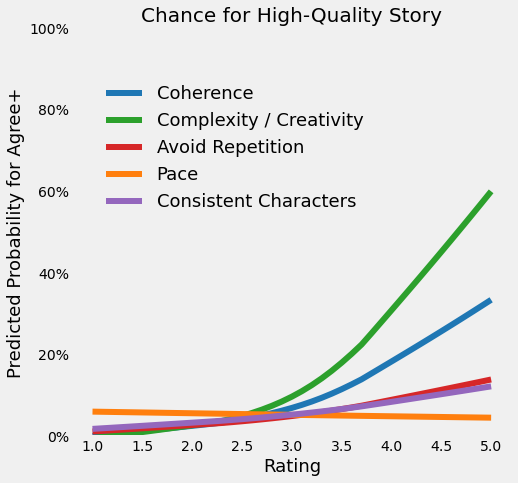

In [137]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent",
                  "tss_conch_cent",
                  "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh", "tab:blue"),
             ("Complexity / Creativity", "tss_cre", "tab:green"),
            ("Avoid Repetition", "tss_avoid_rep", "tab:red"),
             ("Pace", "tss_pac", "tab:orange"),
            ("Consistent Characters", "tss_conch", "tab:purple")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    color = var[2]
    pred_df.rename(columns = {"plot_values": var_full}, inplace = True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 2"] = log_reg_q2.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 2",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True, color = color)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+")
plt.xlabel("Rating")
ax.legend(fontsize=18, frameon = False, bbox_to_anchor = (.7,.9))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Chance for High-Quality Story", fontsize=20)
plt.savefig("graphs/logreg_qual_2.png", bbox_inches="tight")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

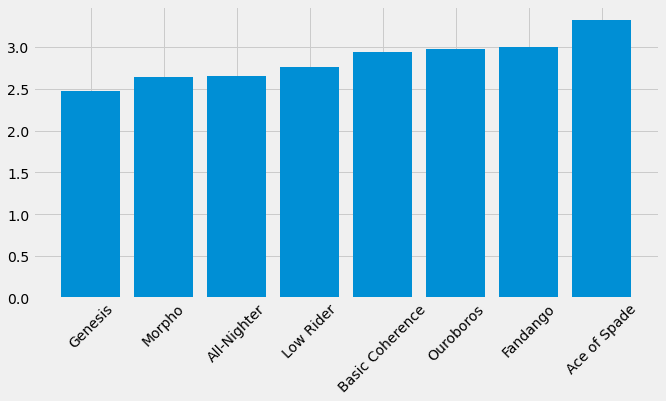

In [139]:
qual = tss_no_out.groupby('preset_label').mean(
)[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_1")

figure = plt.figure(figsize=(10, 5))
plt.bar(qual.index, qual["tss_qua_1"])
plt.xticks(rotation=45)

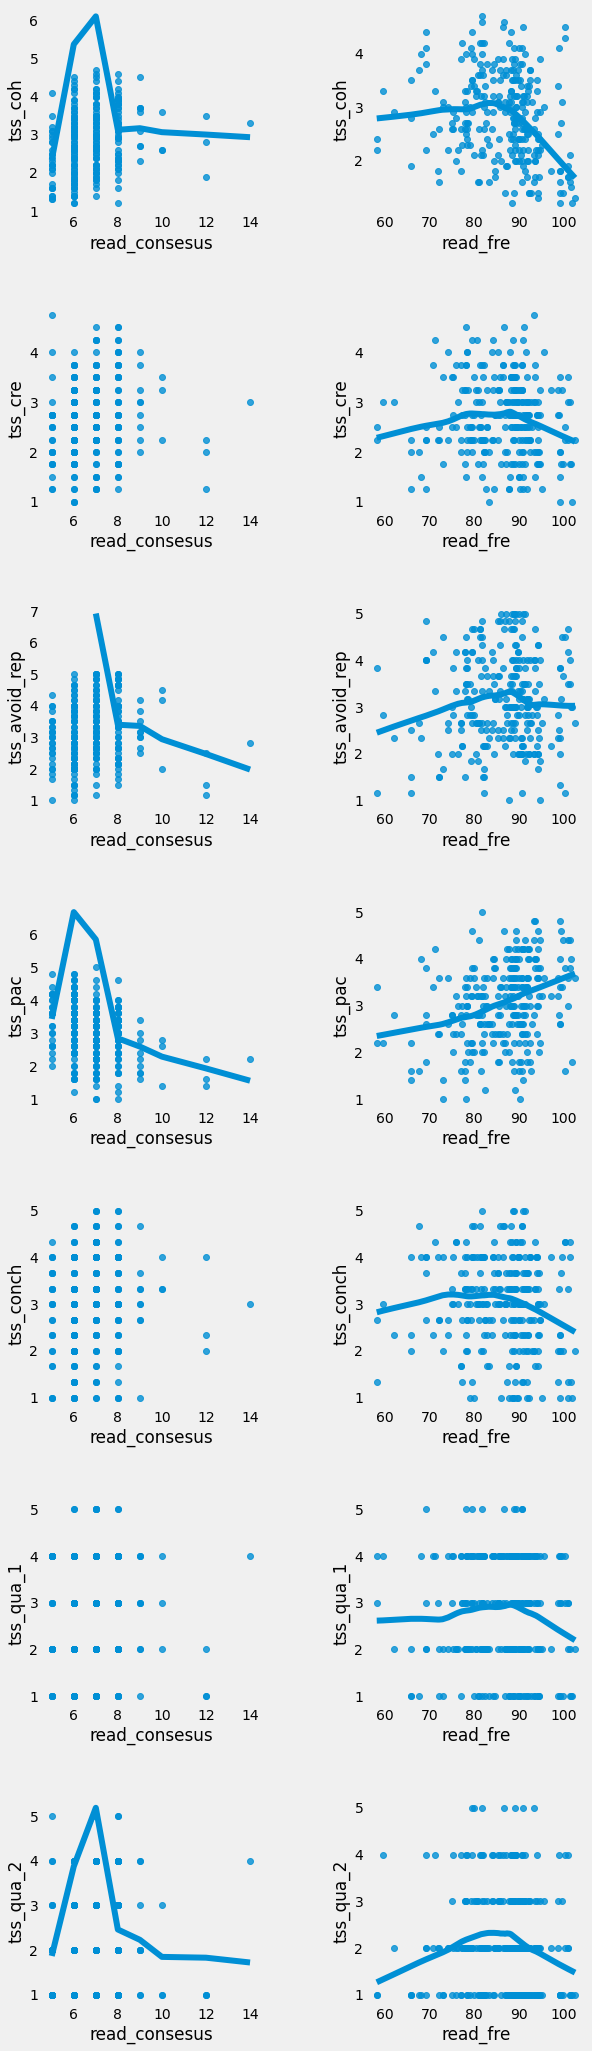

In [142]:
fig, axes = plt.subplots(7, 2, figsize=(10, 30))
fig.tight_layout(pad = 5.0)
plt.grid(False)

sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_consesus", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_fre", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_consesus", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_fre", lowess=True, ax=axes[1, 1])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_consesus", lowess=True, ax=axes[2, 0])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_fre", lowess=True, ax=axes[2, 1])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_consesus", lowess=True, ax=axes[3, 0])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_fre", lowess=True, ax=axes[3, 1])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_consesus", lowess=True, ax=axes[4, 0])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_fre", lowess=True, ax=axes[4, 1])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_consesus", lowess=True, ax=axes[5, 0])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_fre", lowess=True, ax=axes[5, 1])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_consesus", lowess=True, ax=axes[6, 0])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_fre", lowess=True, ax=axes[6, 1])
for ax in fig.axes:
    ax.grid(False)

plt.show()


In [143]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["read_cent"] = tss_df["read_consesus"].apply(
    lambda x: x-tss_df["read_consesus"].mean())  # centering

tss_df["read_cent**2"] = tss_df["read_cent"]*tss_df["read_cent"]
tss_df["read_cent**3"] = tss_df["read_cent"]**3
tss_df["read_cent**4"] = tss_df["read_cent"]**4
tss_df["read_cent**5"] = tss_df["read_cent"]**5

lin_model = linreg()

pred_li = [("linear", "read_cent"), ("quadratic", "read_cent**2"),
           ("cubic", "read_cent**3"), ("quartic", "read_cent**4"),
           ("quintic", "read_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch", "tss_qua_1","tss_qua_2"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

Model performance for linear model predicting tss_coh:
r-square: 0.0404    RMSE: 0.7874
Model performance for quadratic model predicting tss_coh:
r-square: 0.0576    RMSE: 0.7796
Model performance for cubic model predicting tss_coh:
r-square: 0.0557    RMSE: 0.7801
Model performance for quartic model predicting tss_coh:
r-square: 0.0644    RMSE: 0.7763
Model performance for quintic model predicting tss_coh:
r-square: -0.0542    RMSE: 0.8206

Model performance for linear model predicting tss_cre:
r-square: -0.0392    RMSE: 0.7708
Model performance for quadratic model predicting tss_cre:
r-square: -0.0456    RMSE: 0.7709
Model performance for cubic model predicting tss_cre:
r-square: -0.1634    RMSE: 0.8008
Model performance for quartic model predicting tss_cre:
r-square: -0.3204    RMSE: 0.8272
Model performance for quintic model predicting tss_cre:
r-square: -0.5011    RMSE: 0.8534

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0235    RMSE: 0.9621
Model per

In [147]:
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]

marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence", "Low Rider",
                              "All-Nighter"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_conch 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p",
                               "tss_avoid_rep adj_p", "tss_pac adj_p",
                               "tss_conch adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[["Genesis", "Ouroboros", "Basic Coherence", "Low Rider"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_cre", "Complexity / Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_conch", "Consistent Characters")

In [148]:
marg_means_df

,Coherence,Complexity / Creativity,Avoiding Repitition,Pace,Consistent Characters,Coherence 90% CI margin,Complexity / Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Consistent Characters 90% CI margin,Coherence adj_p,Complexity / Creativity adj_p,Avoiding Repitition adj_p,Pace adj_p,Consistent Characters adj_p
Grand Mean,2.858479,2.567053,3.332554,3.110969,2.963073,0.110442,0.105872,0.136325,0.115906,0.152985,NaN,NaN,NaN,NaN,NaN
Genesis,2.555970,2.537539,3.553138,3.225196,2.895408,0.176384,0.183136,0.196105,0.186760,0.229445,0.038297,0.903933,0.257153,0.510116,0.878691
Ouroboros,2.782041,2.628556,3.416936,3.077749,2.994537,0.196760,0.175873,0.219839,0.208983,0.228333,0.836526,0.903933,0.603216,0.868076,0.937926
Basic Coherence,2.873086,2.611573,3.461336,3.132673,3.078363,0.161761,0.204817,0.225361,0.214922,0.252860,0.881923,0.903933,0.601017,0.868076,0.878691
Low Rider,2.918876,2.530578,3.511417,2.943838,2.776364,0.216283,0.176397,0.248272,0.258732,0.270401,0.861334,0.903933,0.601017,0.510116,0.878691
All-Nighter,0.208334,-0.138155,-0.021908,0.137064,0.079724,0.265929,0.205864,0.248538,0.246173,0.297174,0.790133,0.843621,0.884717,0.510116,0.878691


In [163]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col="Preset")
gsheet_df.update(marg_means_df)
gd.set_with_dataframe(gsheet, gsheet_df, include_index=True)

In [ ]:
# mask = ((tss_no_out["prompt_label"] == "Horror") &
#         (tss_no_out["tss_coh"] > 2.37) &
#         (tss_no_out["tss_coh"] < 2.63) &
#         (tss_no_out["tss_avoid_rep"] < 3.15) &
#         (tss_no_out["sample"] == "Community")
#         )

# tss_no_out[mask]

In [ ]:
# print(tss_no_out.loc[132, "full_story"])

In [ ]:
# print(tss_no_out.loc[101, "full_story"])